In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob

In [2]:
# Uncomment and run if you haven't previously installed these packages
# !pip install pillow tifffile natsort imagecodecs microfilm

In [3]:
from PIL import Image
import tifffile
from natsort import natsorted, ns
import imagecodecs
import skimage.io

# Set experiment-specific file locations

In [36]:
# Identify name and virtual machine location of meta data file
# Plate map should list the row and column in number format
# as well as any additional information - strain, media, treatment, etc - in columns
# Note that here I'm using a dummy metadata file, because I do not know conditions for this experiment
# rows defined as drugs A through M, columns defined as technical replicates
meta_data_name = '/home/stoops/Working_Scripts/phenix-data-manipulation/clint-metadata-dummy.csv'

# Identify directory containing images
directory_name = '/data/Phenix-archive/Clint R/Scaber with Peptides 11-12-21 20X__2021-11-12T12_13_27-Measurement 1/Images/'

# Create directories for data storage if they do not already exist
!mkdir -p Data/hyperstacks
!mkdir -p Data/hyperstacks/11-12-21
# Save name of sub-folder you will use for saving the files
subfolder = 'Data/hyperstacks/11-12-21/'

# Define resolution (um)
# Found in "image resolution x [um]"" column of phenix image information
img_resolution = 0.5979761

# Set the names for the channels
ch1_name = 'Alexa488'
ch2_name = 'DAPI'
ch3_name = 'CellMask Deep Red'
ch4_name = 'CD86-PE'

# Import Plate Map

In [5]:
# Import plate map from location on virtual machine
meta_data = pd.read_csv(meta_data_name)

# Extract list of parameters (e.g. drugs, replicates) from metadata
parameters = list(meta_data.columns)
# Exclude row and column position information from list of parameters
if 'row' in parameters: parameters.remove('row')
if 'col' in parameters: parameters.remove('col')
if 'column' in parameters: parameters.remove('column')

# Create list of unique conditions for each parameter (e.g. names of drugs, replicate number)
condition_lists = []
for cnd_type in parameters:
    uniques = np.sort(meta_data[cnd_type].unique())
    condition_lists.append(uniques)

# Make a dictionary that matches the conditions for each parameter with the parameter name
parameter_set = dict(zip(parameters, condition_lists))

# Check that parameter set and dataframe to be sure that metadata was imported and looks accurate
print(parameter_set)
meta_data

{'replicate': array([1, 2, 3]), 'compound': array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
       'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V'], dtype=object)}


,row,column,replicate,compound
0,3,3,1,A
1,3,4,2,A
2,3,5,3,A
3,3,15,1,B
4,3,16,2,B
...,...,...,...,...
61,13,4,2,U
62,13,5,3,U
63,13,15,1,V
64,13,16,2,V


# Generate list of filenames matched with plate map

In [6]:
# Search experiment directory for tiff files and add file path to dataframe
all_paths_list = glob.glob(directory_name + '*.tiff')  
all_paths = pd.DataFrame(all_paths_list, columns = ['path'])

# Regular expression to extract image information (e.g. well position, field of view) from filename
match_str = r'r(?P<row>\d{2})c(?P<column>\d{2})f(?P<fov>\d{2})p(?P<z_position>\d{2})-ch(?P<channel>1|2|3|4)sk(?P<timepoint>\d{1,3})fk1fl1'
extracted = all_paths['path'].str.extract(match_str, expand=True)

# Concatenate extracted information to list of filenames
all_paths_ext = pd.concat([all_paths, extracted], axis=1)

# Convert data extracted from filename from strings to integers
all_paths_ext['row'] = all_paths_ext['row'].astype(int)
all_paths_ext['column'] = all_paths_ext['column'].astype(int)
all_paths_ext['fov'] = all_paths_ext['fov'].astype(int)
all_paths_ext['z_position'] = all_paths_ext['z_position'].astype(int)
all_paths_ext['channel'] = all_paths_ext['channel'].astype(int)
all_paths_ext['timepoint'] = all_paths_ext['timepoint'].astype(int)

# Check that information was added to the dataframe
all_paths_ext.head(10)

,path,row,column,fov,z_position,channel,timepoint
0,/data/Phenix-archive/Clint R/Scaber with Pepti...,12,16,5,1,3,1
1,/data/Phenix-archive/Clint R/Scaber with Pepti...,11,15,3,1,3,1
2,/data/Phenix-archive/Clint R/Scaber with Pepti...,5,5,3,1,3,1
3,/data/Phenix-archive/Clint R/Scaber with Pepti...,4,4,1,1,3,1
4,/data/Phenix-archive/Clint R/Scaber with Pepti...,11,15,4,1,1,1
5,/data/Phenix-archive/Clint R/Scaber with Pepti...,5,5,4,1,1,1
6,/data/Phenix-archive/Clint R/Scaber with Pepti...,4,3,1,1,1,1
7,/data/Phenix-archive/Clint R/Scaber with Pepti...,12,16,2,1,1,1
8,/data/Phenix-archive/Clint R/Scaber with Pepti...,8,5,1,1,1,1
9,/data/Phenix-archive/Clint R/Scaber with Pepti...,7,16,4,1,1,1


In [7]:
# Extract and store details about the experimental setup
nslices = all_paths_ext['z_position'].max()
print(f'Number of slices: {nslices}')
# Choose a default slice number halfway through the stack
if nslices == 1:
    default_z = 1
else:
    default_z = int(nslices/2)
print(f'Default slice: {default_z}')

nchannels = all_paths_ext['channel'].max()
print(f'Number of channels: {nchannels}')

ntimepoints = all_paths_ext['timepoint'].max()
print(f'Number of timepoints: {ntimepoints}')

nfov = all_paths_ext['fov'].max()
print(f'Fields imaged per well: {nfov}')

Number of slices: 1
Default slice: 1
Number of channels: 4
Number of timepoints: 1
Fields imaged per well: 5


In [8]:
# Matches information from the metadata to the information in the dataframe
# This allows us to find and save files based on biological conditions (e.g. treatment) rather than well position
all_files = pd.merge(all_paths_ext, meta_data, how='left', left_on=['row','column'], right_on=['row','column'])

# Create header rows to be able to use these for functions below
all_files.set_index(['compound','replicate','fov','channel','timepoint','z_position'], inplace=True, drop=True)

all_files.head()

,,,,,,path,row,column
compound,replicate,fov,channel,timepoint,z_position,,,
T,2,5,3,1,1,/data/Phenix-archive/Clint R/Scaber with Pepti...,12,16
R,1,3,3,1,1,/data/Phenix-archive/Clint R/Scaber with Pepti...,11,15
E,3,3,3,1,1,/data/Phenix-archive/Clint R/Scaber with Pepti...,5,5
C,2,1,3,1,1,/data/Phenix-archive/Clint R/Scaber with Pepti...,4,4
R,1,4,1,1,1,/data/Phenix-archive/Clint R/Scaber with Pepti...,11,15


# Save images

In [23]:
# Function definition

def create_stack(compound,replicate=1,fov=1,z_pos=default_z, **kwargs):
    '''
    Creates stack compiling all of the timepoints for the parameters specified and saves to hyperstack
    
    Parameters:
    compound (str): drug condition
    replicate (int): biological replicate
    fov (int): field of view within the well
    z_pos (int): position within the z-stack
    
    '''    
    
    # Generate the set of filenames where the conditions are equal to those set when calling the function
    image_path = all_files.xs((compound,replicate,fov,z_pos), 
                              level=['compound','replicate','fov','z_position'])['path'].values[:]
    # Sort the pathnames using a package that puts in natural order despite absence of leading zeroes
    paths_sorted = natsorted(image_path, key=lambda y: y.lower())
    
    # Create filename for saving
    file_name = subfolder + compound + '_r' + str(replicate) + '_f' + str(fov) + '_z' + str(z_pos) + '.tif'
    
    # Create an empty numpy array
    multichan_im = np.zeros((nchannels,1080,1080))
    
    # Fill numpy array with images for all channels in channel list
    for col_num in range(nchannels):
        multichan_im[col_num,:,:] = plt.imread(paths_sorted[col_num])
    
    # Define metadata to be used for ImageJ
    metadata = {'channels':nchannels,'unit': 'um','hyperstack':True,'loop':False}
    # Save file to subfolder with metadata and resolution information
    skimage.external.tifffile.imsave(file_name, multichan_im.astype(np.uint16), imagej = True, 
                                     resolution = (1/img_resolution,1/img_resolution), metadata = metadata)

In [20]:
# Generate lists for the unique parameters
unique_compounds = parameter_set["compound"].tolist()
print(unique_compounds)
unique_fovs = np.sort(all_paths_ext["fov"].unique()).tolist()
print(unique_fovs)
unique_replicates = parameter_set["replicate"].tolist()
print(unique_replicates)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V']
[1, 2, 3, 4, 5]
[1, 2, 3]


In [24]:
# Loop through conditions to save a subset of conditions defined in brackets
for rep in [1]:
    for cpd in ['C','D']:
        for fov in [1,5]:
            create_stack(compound=cpd,replicate=rep,fov=fov,z_pos=default_z)

In [ ]:
# Loop through conditions to save all files
for rep in unique_replicates:
    for cpd in unique_compounds:
        for fov in unique_fovs:
            create_stack(compound=cpd,replicate=rep,fov=fov,z_pos=default_z)

# Tester functions

In [43]:
# Define functions that can be used to produce images within the notebook
# Use these to probe different conditions without having to export all files

def return_image(compound,replicate,fov,channel=1,timepoint=1,z_pos=default_z, **kwargs):
    '''
    Returns image specified by arguments passed to the function
    
    Parameters:
    compound (str): drug condition
    replicate (int): biological replicate to plot
    fov (int): field of view within the well to plot
    channel (int): channel number to plot
    timepoint (int): timepoint to plot
    z_pos (int): position within the z-stack to plot
    
    '''
    
    # Generate the set of filenames where the conditions are equal to those set when calling the function
    image_path = all_files.xs((compound,replicate,fov,channel,timepoint,z_pos), 
                              level=['compound','replicate','fov','channel','timepoint','z_position'])['path'].values[0]
    
    # Load the images associated with the above filenames into numpy arrays
    img = plt.imread(image_path)
    
    return img

def plot_specific_image(compound,replicate,fov,channel,timepoint,z_pos, **kwargs):
    '''
    Plots image specified by arguments passed to the function
    
    Parameters:
    compound (str): drug condition
    replicate (int): biological replicate to plot
    fov (int): field of view within the well to plot
    channel (int): channel number to plot
    timepoint (int): timepoint to plot
    z_pos (int): position within the z-stack to plot
    
    '''
    
    # Load the images associated with the above filenames into numpy arrays
    img = return_image(compound,replicate,fov,channel,timepoint,z_pos)
    img_min = np.percentile(img, 2)
    img_max = np.percentile(img, 99.8)
    
    # Display image with title and no axes
    plt.imshow(img, cmap='gray', vmin=img_min, vmax=img_max)
    plt.suptitle(compound + ' (rep ' + str(replicate) + ')')
    plt.xticks([])
    plt.yticks([])
    plt.show()


def plot_multichannel_image(compound,replicate=1,fov=1,timepoint=1,z_pos=default_z, **kwargs):
    '''
    Plots 2-color image specified by arguments passed to the function
    
    Parameters:
    compound (str): drug condition
    replicate (int): biological replicate to plot
    fov (int): field of view within the well to plot
    timepoint (int): timepoint to plot
    z_pos (int): position within the z-stack to plot
    
    '''
    
    # Generate the set of filenames where the conditions are equal to those set when calling the function
    image_path = all_files.xs((compound,replicate,fov,timepoint,z_pos), 
                              level=['compound','replicate','fov','timepoint','z_position'])['path'].values[:]
    paths_sorted = np.sort(image_path)
    
    # Create figure object
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4,figsize=(8,3))
    
    # Read and plot channel 1
    ch1 = plt.imread(paths_sorted[0])
    ch1_min = np.percentile(ch1, 2)
    ch1_max = np.percentile(ch1, 99.8)
    ax1.imshow(ch1, cmap='gray', vmin=ch1_min, vmax=ch1_max)
    ax1.set_title(ch1_name)
    ax1.axis('off')
    
    # Read and plot channel 2
    ch2 = plt.imread(paths_sorted[1])
    ch2_min = np.percentile(ch2, 2)
    ch2_max = np.percentile(ch2, 99.8)
    ax2.imshow(ch2, cmap='gray', vmin=ch2_min, vmax=ch2_max)
    ax2.set_title(ch2_name)
    ax2.axis('off')
    
    # Read and plot channel 3
    ch3 = plt.imread(paths_sorted[2])
    ch3_min = np.percentile(ch3, 2)
    ch3_max = np.percentile(ch3, 99.8)
    ax3.imshow(ch3, cmap='gray', vmin=ch3_min, vmax=ch3_max)
    ax3.set_title(ch3_name)
    ax3.axis('off')
    
    # Read and plot channel 4
    ch4 = plt.imread(paths_sorted[3])
    ch4_min = np.percentile(ch4, 2)
    ch4_max = np.percentile(ch4, 99.8)
    ax4.imshow(ch4, cmap='gray', vmin=ch4_min, vmax=ch4_max)
    ax4.set_title(ch4_name)
    ax4.axis('off')
    
    plt.suptitle(compound + ' (rep ' + str(replicate) + ')', fontsize=20)
    plt.show()
    

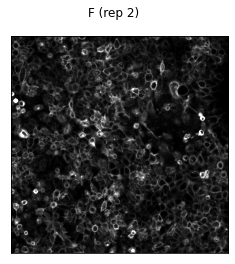

In [27]:
# Displays image for parameters specified
plot_specific_image(compound='F',replicate=2,fov=1,channel=1,timepoint=1,z_pos=1)

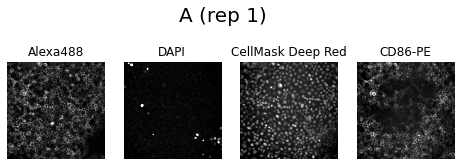

In [44]:
# Plots 4 channels side by side for given condition
plot_multichannel_image('A')